# Simple Speed Recognition of Digits using Discrete HMM

In [0]:
#@title Install HMMLearn

!pip install hmmlearn

In [0]:
#@title Imports

import sys
import glob

import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
import sklearn
import scipy.io.wavfile as wav
import hmmlearn.hmm

In [0]:
#@title Clone data and MFCC library

!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git
!git clone https://github.com/jameslyons/python_speech_features.git


In [0]:
#@title More Imports

sys.path.append('python_speech_features')

from python_speech_features import mfcc
from python_speech_features import delta
from python_speech_features import logfbank


In [0]:
#@title Cluster & HMM Parameters
n_clusters = 100 #@param {type:"integer"}
n_components=50 #@param {type:"integer"}

In [0]:
#@title Load Data & Generate Features
signals = {}
fbanks = {}

for i in xrange(10):
  signals[i] = [wav.read(f)[1] for f in glob.glob("free-spoken-digit-dataset/recordings/%i_*.wav" % i)]
  fbanks[i] = [logfbank(sig,8000) for sig in signals[i]]

#fbank_concat = {k: np.concatenate([f for f in banks], axis=0) for k, banks in fbanks.iteritems()}
fbank_lens = {k: [f.shape[0] for f in banks] for k, banks in fbanks.iteritems()}

train_fbanks = {}
train_concat_fbanks = {}
train_fbank_lens = {}

test_fbanks = {}


for i in xrange(10):
  train, test = sklearn.model_selection.train_test_split(fbanks[i], test_size=0.1)
  train_fbanks[i] = train
  test_fbanks[i] = test
  
  train_concat_fbanks[i] = np.concatenate(train_fbanks[i], axis=0)
  train_fbank_lens[i] = [f.shape[0] for f in train_fbanks[i]]
  
all_fbank = np.concatenate([f for banks in train_fbanks.itervalues() for f in banks], axis=0)

In [0]:
#@title Cluster Training MFCC Vectors

kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters).fit(all_fbank)


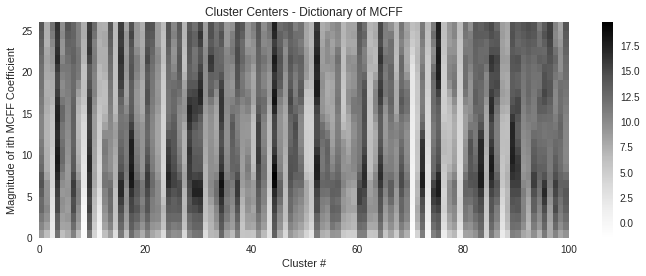

In [0]:
#@title Plot Clusters
plt.figure(figsize=(10, 4))
plt.pcolormesh(kmeans.cluster_centers_.T)
plt.colorbar()
plt.title('Cluster Centers - Dictionary of MCFF')
plt.xlabel("Cluster #")
plt.ylabel("Magnitude of ith MCFF Coefficient")
plt.tight_layout()
plt.show()

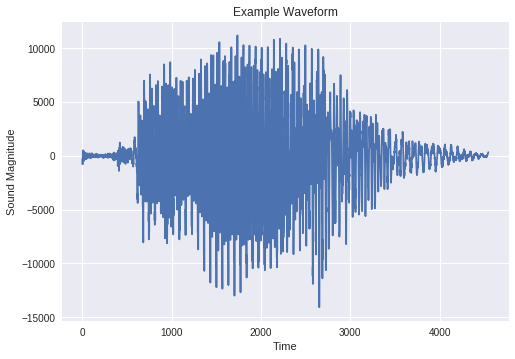

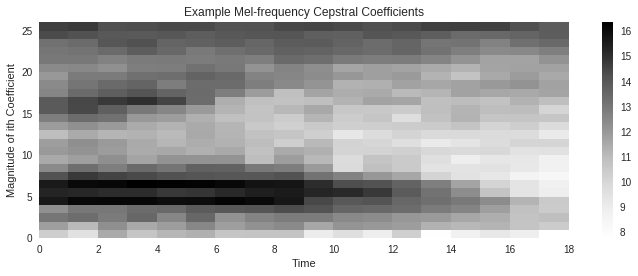

In [0]:
#@title Example Waveform and Mel-frequency Cepstral Coefficients

sig = signals[3][1]
fbank_feat = train_fbanks[3][1]

plt.plot(range(len(sig)),sig)
plt.xlabel("Time")
plt.ylabel("Sound Magnitude")
plt.title("Example Waveform")
plt.show()

plt.figure(figsize=(10, 4))
plt.pcolormesh(fbank_feat.T)
plt.colorbar()
plt.title('Example Mel-frequency Cepstral Coefficients')
plt.xlabel("Time")
plt.ylabel("Magnitude of ith Coefficient")
plt.tight_layout()
plt.show()

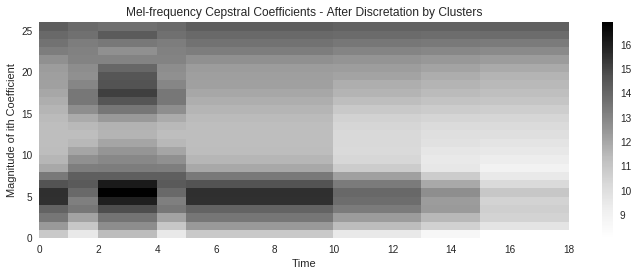

In [0]:
#@title Example Waveform transformed using Cluster Dictionary

clusters = kmeans.predict(fbank_feat).reshape(-1, 1)

plt.figure(figsize=(10, 4))
plt.pcolormesh(kmeans.cluster_centers_[clusters.reshape(-1)].T)
plt.colorbar()
plt.title('Mel-frequency Cepstral Coefficients - After Discretation by Clusters')
plt.xlabel("Time")
plt.ylabel("Magnitude of ith Coefficient")
plt.tight_layout()
plt.show()

In [0]:
#@title Train HMMs (One for each word)

hmms = {}

for k, fb in train_concat_fbanks.iteritems():
  hmms[k] = hmmlearn.hmm.MultinomialHMM(n_components=n_components)
  hmms[k].n_features = n_clusters
  clusters = np.append(kmeans.predict(fb), range(n_clusters)).reshape(-1, 1)
  hmms[k].fit(clusters, lengths=np.append(train_fbank_lens[k], [n_clusters]))


In [0]:
#@title Calculate Train and Test Predictions

train_log_probs = np.array([]).reshape(0,10)
test_log_probs = np.array([]).reshape(0,10)

train_labels = []
test_labels = []

train_predictions = []
test_predictions = []

for i in xrange(10):
  for fb in test_fbanks[i]:
    log_probs = np.array([[hmms[j].score(kmeans.predict(fb).reshape(-1, 1)) for j in xrange(10)]]).reshape(1,-1)
    test_log_probs = np.concatenate((test_log_probs, log_probs), axis=0)
    test_labels.append(i)
    test_predictions.extend(np.argmax(log_probs, axis=1))
  
  for fb in train_fbanks[i]:
    log_probs = np.array([[hmms[j].score(kmeans.predict(fb).reshape(-1, 1)) for j in xrange(10)]]).reshape(1,-1)
    train_log_probs = np.concatenate((train_log_probs, log_probs), axis=0)
    train_labels.append(i)
    train_predictions.extend(np.argmax(log_probs, axis=1))

print("Train accuracy: %f" % sklearn.metrics.accuracy_score(train_labels, train_predictions))
print("Test accuracy: %f" % sklearn.metrics.accuracy_score(test_labels, test_predictions))

Train accuracy: 0.925556
Test accuracy: 0.875000


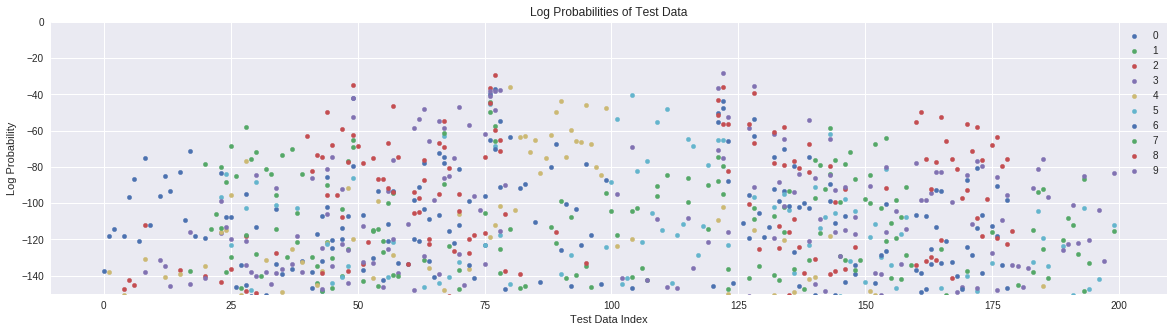

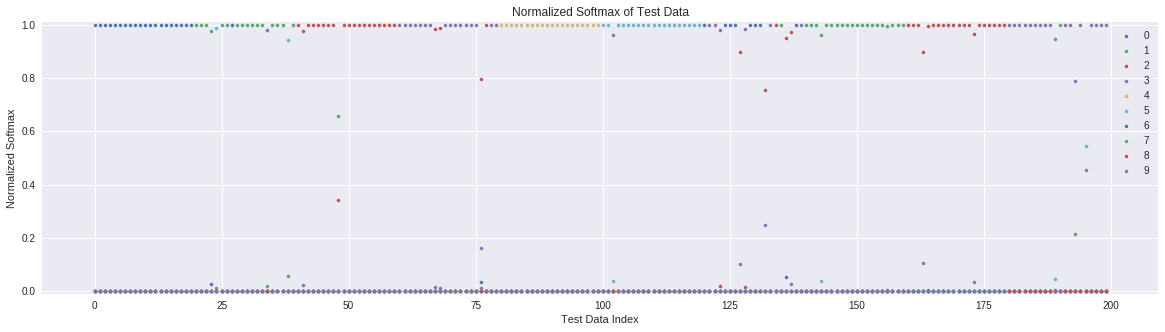

In [0]:
#@title Plot Log Probabilies & Normalized Softmax of Test Data 

tmp = np.exp(test_log_probs - np.max(test_log_probs, axis=1).reshape(-1,1))
softmax = np.divide(tmp,np.sum(tmp, axis=1).reshape(-1,1))

plt.figure(figsize=(20,5))

for i in xrange(10):
  plt.scatter(range(test_log_probs.shape[0]), test_log_probs[:,i], label=i, s=20)
plt.ylim([-150,0])
plt.legend()
plt.xlabel("Test Data Index")
plt.ylabel("Log Probability")
plt.title("Log Probabilities of Test Data")
plt.show()


plt.figure(figsize=(20,5))
for i in xrange(10):
  plt.scatter(range(softmax.shape[0]), softmax[:,i], label=i, s=10)
plt.ylim([-0.01, 1.01])
plt.legend()
plt.xlabel("Test Data Index")
plt.ylabel("Normalized Softmax")
plt.title("Normalized Softmax of Test Data")
plt.show()